In [8]:
using Plots, Interact, LinearAlgebra
using Random: randperm
using Statistics: mean

theme(
    :wong;
    markerstrokecolor="white", 
    markerstrokewidth=0,
    alpha=0.6,
    label=""
)

function heatmap_digit(x::AbstractMatrix; kwargs...)
    return heatmap(
        x;
        transpose=true,
        yflip=true,
        showaxis=:false,
        grid=:false,
        color=:grays,
        aspect_ratio=1.0,
        kwargs...
    )
end

heatmap_digit (generic function with 1 method)

In [9]:
"""
    Y = g(X, W, b, f_a)

Pass input `X` into a neural network with activation function `f_`,
    weight matrix `W`, and bias vector `b`, returning the corresponding outputs.
    
**Inputs**
* `X`: *d* x *N* matrix representing *N* samples with *d* dimensions
* `W`: *n* x *d* weight matrix, where *n* is the hidden layer dimension
* `b`: length-*n* bias vector
* `f_a`: activation function

**Output**: `Y`, the *1* x *N* matrix of outputs corresponding to the *N* samples
"""
function g(X::AbstractArray, W::AbstractMatrix, b::AbstractVector, f_a::Function)
    return sum(f_a.(W * X .+ b); dims=1)
end

g

In [10]:
"""
    dW, db, loss = grad_loss_1layer_1output(f_a, df_a, X, y, W, b)

Evaluate the loss function and its gradient at `X`.

**Inputs**
* `f_a`, `df_a`: activation function and its derivative, respectively
* `X`: *d* x *N* input matrix (*N* samples with dimension *d*)
* `y`: *1* x *N* output vector (function values corresponding to the *N* samples in `X`)
* `W`: *n* x *d* weight matrix, where n is the hidden layer dimension
* `b`: length-*n* bias vector

**Outputs**
* `dW`: vector of gradients with respect to weights
* `db`: gradient with respect to bias
* `loss`: loss function value
"""
function grad_loss_1layer_1output(
        f_a::Function,
        df_a::Function,
        X::AbstractMatrix,
        y::AbstractMatrix,
        W::AbstractMatrix,
        b::AbstractVector
    )

    n, d = size(W)
    N = size(X, 2)

    dW = zeros(n, d)
    db = zeros(n)
    loss = 0.0

    for k in 1:N
        error = y[k] - sum(f_a.(W * X[:, k] + b))
        for p in 1:n
            for q in 1:d
                dW[p, q] -= 2 / N * error * df_a(W[p, :]' * X[:, k] + b[p]) * X[q, k]
            end
            db[p] -= 2 / N * error * df_a(W[p, :]' * X[:, k] + b[p])
        end

        loss += 1/N * error^2
    end
    return dW, db, loss
end

grad_loss_1layer_1output

In [11]:
using Random: randperm, seed!

"""
    W, b, loss = learn2classify_sgd_1layer(f_a, df_a, grad_loss, X, y, W0, b0[,
        mu=1e-3, iters=500, batch_size=10, seed=0])

Perform stochastic gradient descent and return optimized weights `W`, bias `b`,
    and vector of loss function values `loss`.

**Inputs**
* `f_a`, `df_a`: activation function and its derivative, respectively
* `grad_loss`: gradient of the loss function
* `X`: d x N matrix representing N samples having dimension d
* `y`: 1 x N row matrix containing scalar function values for the N input samples
* `W0`: n x d initial weight matrix, where n is the hidden layer dimension
* `b0`: length-n initial bias vector
* `mu`: gradient descent step size
* `iters`: number of gradient descent iterations to perform
* `batch_size`: number of samples to use for each iteration
* `seed`: specify a random seed for batch selection

**Outputs**
* `W`: optimized matrix of weights
* `b`: optimized bias vector
* `loss`: vector of loss function values for all iterations
"""
function learn2classify_sgd_1layer(
        f_a::Function,
        df_a::Function,
        grad_loss::Function,
        X::AbstractMatrix,
        y::AbstractMatrix,
        W0::AbstractMatrix,
        b0::AbstractVector,
        mu::Number=1e-3,
        iters::Integer=500,
        batch_size::Integer=10,
        seed::Integer=0
    )
    
    (seed != 0) && seed!(seed) # use seed if provided
    
    n, d = size(W0) # number of hidden neurons, inputs
    N = size(X, 2) # number of training samples
 
    W = W0
    b = b0
    loss = zeros(iters)
    for i in 1:iters
        batch_idx = randperm(N)
        batch_idx = batch_idx[1:min(batch_size, N)]
        
        dW, db, loss_i = grad_loss(
            f_a, df_a, X[:, batch_idx], y[:, batch_idx], W, b)
        
        W -= mu * dW
        b -= mu * db

        loss[i] = loss_i
    end
    return W, b, loss
end

learn2classify_sgd_1layer

In [12]:
using Random: randperm, seed!

"""
    W, b, loss = learn2classify_asgd_1layer(f_a, df_a, grad_loss, X, y, W0, b0[,
        mu=1e-3, iters=500, batch_size=10, seed=0])

Perform accelerated stochastic gradient descent and return optimized weights
    `W`, bias `b`, and vector of loss function values `loss`.

**Inputs**
* `f_a`, `df_a`: activation function and its derivative, respectively
* `grad_loss`: gradient of the loss function
* `X`: d x N matrix representing N samples having dimension d
* `y`: 1 x N row matrix containing scalar function values for the N input samples
* `W0`: n x d initial weight matrix, where n is the hidden layer dimension
* `b0`: length-n initial bias vector
* `mu`: gradient descent step size
* `iters`: number of gradient descent iterations to perform
* `batch_size`: number of samples to use for each iteration
* `seed`: specify a random seed for batch selection

**Outputs**
* `W`: optimized matrix of weights
* `b`: optimized bias vector
* `loss`: vector of loss function values for all iterations
"""
function learn2classify_asgd_1layer(
        f_a::Function, 
        df_a::Function, 
        grad_loss::Function,
        X::AbstractMatrix, 
        y::AbstractMatrix, 
        W0::AbstractMatrix, 
        b0::AbstractVector,
        mu::Number=1e-3, 
        iters::Integer=500, 
        batch_size::Integer=10,
        seed::Integer=0
    )
    
    (seed != 0) && seed!(seed) # use seed if provided

    d = size(W0, 2) #number of inputs
    n = size(W0, 1) # number of neurons
    N = size(X, 2) # number of training samples
 
    W = W0
    b = b0
    
    loss = zeros(iters)

    lambda_k = 0
    q_k = W
    p_k = b
    for i in 1:iters
        batch_idx = randperm(N)
        batch_idx = batch_idx[1:min(batch_size, N)]
        
        dW, db, loss_i = grad_loss(f_a, df_a, X[:, batch_idx], y[:, batch_idx], W, b)
        
        q_kp1 = W - mu * dW
        p_kp1 = b - mu * db

        lambda_kp1 = (1 + sqrt(1 + 4 * lambda_k^2)) / 2
        gamma_k = (1 - lambda_k) / lambda_kp1

        W = (1 - gamma_k) * q_kp1 + gamma_k * q_k
        b = (1 - gamma_k) * p_kp1 + gamma_k * p_k

        q_k = q_kp1
        p_k = p_kp1
        lambda_k = lambda_kp1

        loss[i] = loss_i
    end
    return W, b, loss
end

learn2classify_asgd_1layer

In [13]:
"""
    y = dtanh(x)

Evaluate the derivative of the tangent function at `x`.
"""
dtanh(x::Number) = 1 - tanh(x).^2

"""
    y = linear(x)

Evaluate the linear function at `x`.
"""
linear(x::Number) = x

"""
    y = dlinear(x)

Evaluate the derivative of the linear function at `x`.
"""
dlinear(x::Number) = 1.0

dlinear

In [14]:
N = 200
X_train = range(-1; stop=1, length=N) |> collect |> permutedims 
y_train = X_train.^2

1×200 Array{Float64,2}:
 1.0  0.980001  0.960203  0.940608  …  0.940608  0.960203  0.980001  1.0

In [15]:
f_a, df_a = tanh, dtanh
n, d = 8, 1 #  sets 8 neurons in hidden layer and conveys that we are working with scalar input
iters = 5000
batch_size = 20
W0, b0 = randn(n, d), randn(n) # this initalizes them as random normally distributed numbers
mu = 1e-1 # start with 1e1 and make lower till network learns

(W_sgd_8, b_sgd_8, loss_sgd_8), time_sgd_8 = @timed learn2classify_sgd_1layer(
    f_a, df_a, grad_loss_1layer_1output,
    X_train, y_train, W0, b0, mu, iters, batch_size
)
println("SGD training loss is $(loss_sgd_8[end])")

SGD training loss is 0.00029936360414725287


In [16]:
"""
    p = scatter_training_loss(training_loss[, downsample_idx])

Return a semilog plot of training loss vs iteration, using `downsample_idx` to
    show only a subset of points. (By default, only every 10th point is shown.)
"""
function scatter_training_loss(training_loss, downsample_idx=1:10:length(training_loss); kwargs...)
    return scatter(
        downsample_idx, training_loss[downsample_idx];
        alpha=0.3,
        yscale=:log10,
        ylabel="Training loss (log)",
        xlabel="Iteration",
        kwargs...
    )
end

function scatter_training_loss!(training_loss, downsample_idx=1:5:length(training_loss); kwargs...)
    return scatter!(
        downsample_idx, training_loss[downsample_idx];
        alpha=0.3,
        yscale=:log10,
        ylabel="Training loss (log)",
        xlabel="Iteration",
        kwargs...
    )
end

scatter_training_loss! (generic function with 2 methods)

In [17]:
scatter_training_loss(
    loss_sgd_8;
    color=:red,
    label="SGD, 8 hidden layer neurons, training time = $(round(time_sgd_8; digits=3))s"
)
println("Training loss is $(loss_sgd_8[end])")

Training loss is 0.00029936360414725287


In [18]:
# 50 new input points that do not belong to X_train
X_test = range(-0.8; stop=0.8, length=50) |> collect |> permutedims
y_test_actual = X_test.^2

y_test_sgd_8 = g(X_test, W_sgd_8, b_sgd_8, f_a)
@show test_loss_sgd_8 = mean((y_test_sgd_8 - y_test_actual).^2);

println("Loss is $test_loss_sgd_8")

test_loss_sgd_8 = mean((y_test_sgd_8 - y_test_actual) .^ 2) = 0.00016162654872866022
Loss is 0.00016162654872866022


In [19]:
function scatter_fit(X, y; kwargs...)
    return scatter(
        vec(X), vec(y);
        alpha=0.3,
        xlabel="x",
        ylabel="f(x)",
        kwargs...
    )
end

function scatter_fit!(X, y; kwargs...)
    return scatter!(
        vec(X), vec(y);
        alpha=0.5,
        xlabel="x",
        ylabel="f(x)",
        kwargs...
    )
end

scatter_fit! (generic function with 1 method)

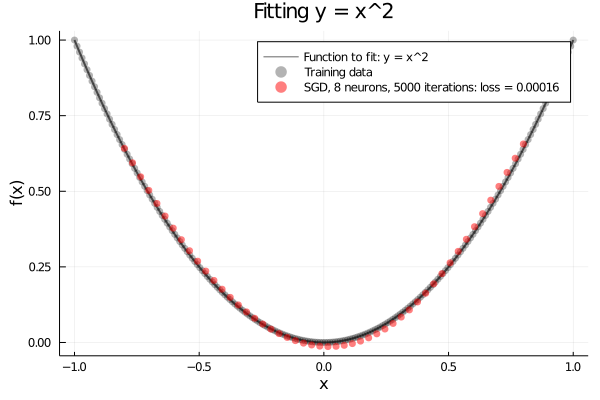

In [20]:
plot(
    -1:0.01:1, (-1:0.01:1).^2;
    color=:black,
    lw=2,
    label="Function to fit: y = x^2",
    title="Fitting y = x^2"
)

scatter_fit!(X_train, y_train; color=:black, label="Training data", alpha=0.3)

scatter_fit!(
    X_test, y_test_sgd_8;
    color=:red,
    label="SGD, 8 neurons, $iters iterations: loss = $(round(test_loss_sgd_8; digits=5))"
)

In [21]:
n, d = 16, 1
W0, b0  = randn(n, d), randn(n)

(W_sgd_16, b_sgd_16, loss_sgd_16), time_sgd_16 = @timed learn2classify_sgd_1layer(
    f_a, df_a, grad_loss_1layer_1output,
    X_train, y_train, W0, b0, mu, iters, batch_size
)

@show time_sgd_16
@show loss_sgd_16[end];

time_sgd_16 = 2.8812642
loss_sgd_16[end] = 7.353042685805155e-5


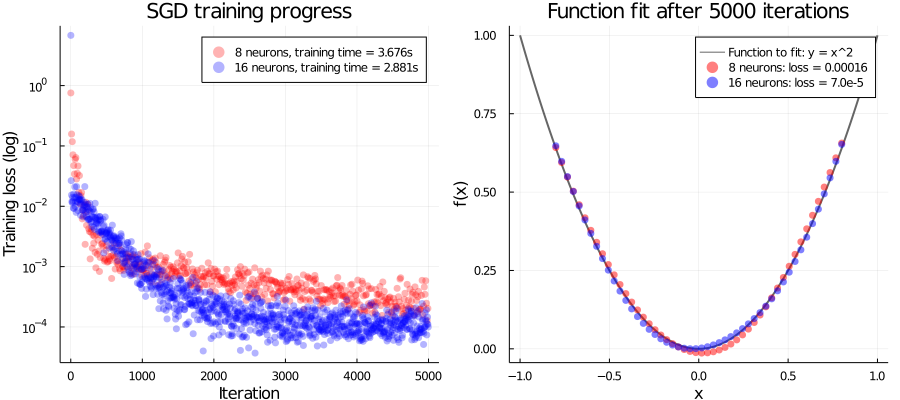

In [22]:
y_test_sgd_16 = g(X_test, W_sgd_16, b_sgd_16, f_a) 
test_loss_sgd_16 = mean((y_test_sgd_16 - y_test_actual).^2)

p_loss = scatter_training_loss(
    loss_sgd_8;
    color=:red,
    label="8 neurons, training time = $(round(time_sgd_8; digits=3))s",
    title="SGD training progress"
)

scatter_training_loss!(
    loss_sgd_16;
    color=:blue,
    label="16 neurons, training time = $(round(time_sgd_16; digits=3))s"
)

p_fit = plot(
    -1:0.01:1, (-1:0.01:1).^2;
    color=:black,
    lw=2,
    label="Function to fit: y = x^2",
    title="Function fit after $iters iterations"
)

scatter_fit!(
    X_test, y_test_sgd_8;
    color=:red,
    label="8 neurons: loss = $(round(test_loss_sgd_8; digits=5))"
)

scatter_fit!(
    X_test, y_test_sgd_16;
    color=:blue,
    label="16 neurons: loss = $(round(test_loss_sgd_16; digits=5))"
)

plot(p_loss, p_fit; size=(900, 400))

In [23]:
n, d = 16, 1
# W0, b0  = randn(n, d), randn(n)  # this keeps the initialized weights the same as for SGD

(W_asgd_16, b_asgd_16, loss_asgd_16), time_asgd_16 = @timed learn2classify_asgd_1layer(
        f_a, df_a, grad_loss_1layer_1output,
        X_train, y_train, W0, b0, mu, iters, batch_size
)
y_test_asgd_16 = g(X_test, W_asgd_16, b_asgd_16, f_a)

@show test_loss_asgd_16 = mean((y_test_asgd_16 - y_test_actual).^2);

test_loss_asgd_16 = mean((y_test_asgd_16 - y_test_actual) .^ 2) = 3.215787505422529e-8


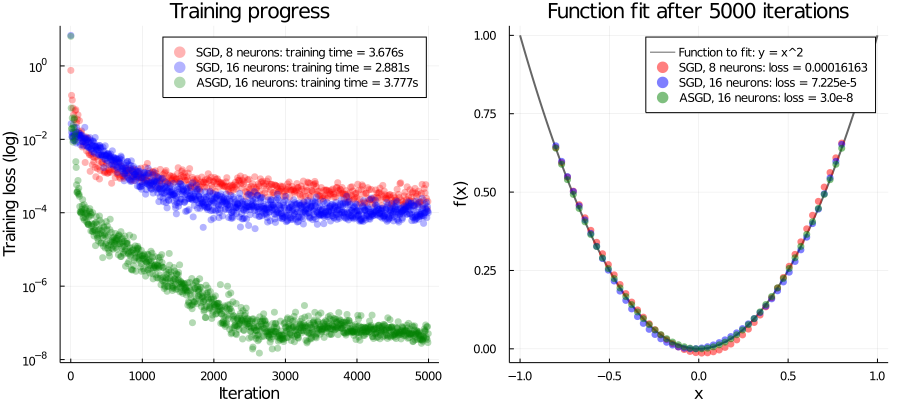

In [24]:
p_loss = scatter_training_loss(
    loss_sgd_8;
    color=:red,
    label="SGD, 8 neurons: training time = $(round(time_sgd_8; digits=3))s",
    title="Training progress"
)

scatter_training_loss!(
    loss_sgd_16;
    color=:blue,
    label="SGD, 16 neurons: training time = $(round(time_sgd_16; digits=3))s"
)

scatter_training_loss!(
    loss_asgd_16;
    color=:green,
    label="ASGD, 16 neurons: training time = $(round(time_asgd_16; digits=3))s"
)


p_fit = plot(
    -1:0.01:1, (-1:0.01:1).^2;
    color=:black,
    lw=2,
    label="Function to fit: y = x^2",
    title="Function fit after $iters iterations"
)

scatter_fit!(
    X_test, y_test_sgd_8;
    color=:red,
    label="SGD, 8 neurons: loss = $(round(test_loss_sgd_8; digits=8))"
)

scatter_fit!(
    X_test, y_test_sgd_16;
    color=:blue,
    label="SGD, 16 neurons: loss = $(round(test_loss_sgd_16; digits=8))"
)

scatter_fit!(
    X_test, y_test_asgd_16;
    color=:green,
    label="ASGD, 16 neurons: loss = $(round(test_loss_asgd_16; digits=8))"
)
plot(p_loss, p_fit; size=(900, 400))

In [25]:
"""
    X = point_cloud(μ, Σ, N)

Return a d x *N* array representing *N* *d*-dimensional points, where `d = length(μ)`.
    Points are normally distributed along each dimension, with mean values given by
    `μ` and standard deviations given by `Σ`.
"""
function point_cloud(μ::Vector, Σ::AbstractMatrix, N)
    d = size(μ, 1)

    return μ .+ sqrt(Σ) * randn(d, N)
end

point_cloud

In [26]:
μ1, μ2 = [1; 0], [-1, 0]
Σ = Diagonal([0.01; 1])
N = 100

X1 = point_cloud(μ1, Σ, N)
X2 = point_cloud(μ2, Σ, N)

2×100 Array{Float64,2}:
 -1.12028  -0.998673  -0.958807  -1.12507  …  -0.947695  -0.906264  -0.995082
 -1.04972   0.129606   0.442265   1.06352      1.63964    0.156995  -1.44259

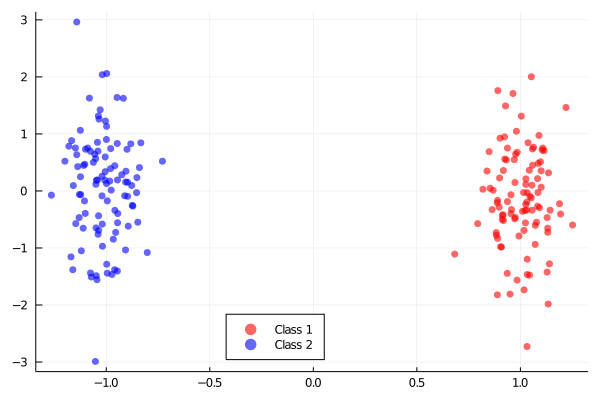

In [27]:
"Convenience method for plotting X[2, :] against X[1, :]"
scatter2d(X::AbstractMatrix; kwargs...) = scatter(X[1, :], X[2, :]; kwargs...)

"Add a scatter2d plot to an existing plot"
scatter2d!(X::AbstractMatrix; kwargs...) = scatter!(X[1, :], X[2, :]; kwargs...)

scatter2d(X1; color="red", label="Class 1", legend=:bottom)
scatter2d!(X2; color="blue", label="Class 2")

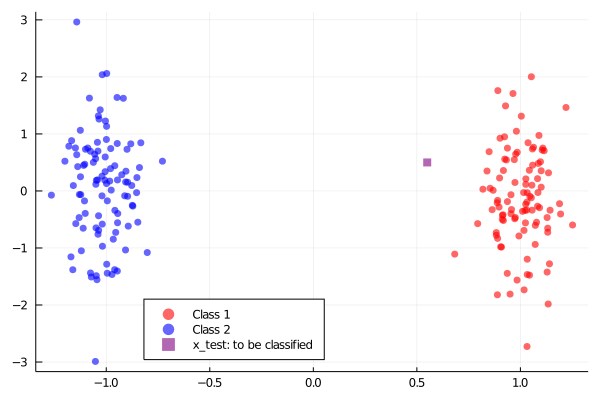

In [28]:
x_test = [0.55, 0.5] # test vector
scatter2d(X1; color="red", label="Class 1", legend=:bottom)
scatter2d!(X2; color="blue", label="Class 2")
scatter!(x_test[1, :], x_test[2, :]; color="purple", marker=:square, label="x_test: to be classified")

In [29]:
x1range = range(-5; stop=5, length=100)
x2range = range(-5; stop=5, length=100)

# if the manipuate cell does not work comment out the next few lines 
# and the end statement and manually enter values for the parameters
@manipulate for w₁ in (-1.0, -0.5, 0.0, 0.5, 1.0),
                w₂ in (-1.0, -0.5, 0.0, 0.5, 1.0),
                b in (-1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0),
                show_sign_only = true

    D = [x1 * w₁ + x2 * w₂ + b for x2 in x2range, x1 in x1range]
    if show_sign_only
        D = sign.(D)
    end

    heatmap(x1range, x2range, D; color=:grays)
    scatter2d!(X1; color="red", label="class 1")
    scatter2d!(X2; color="blue", label="class 2")
    scatter!(
        x_test[1, :], x_test[2, :]; 
        color="purple", 
        marker=:square,
        label="x = point to be classified",
        legend=:bottomleft
    )        
end

var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \&quot;0\&quot;) &amp;&amp; ([\&quot;-0\&quot;, \&quot;-0.\&quot;].indexOf(stringified()) &gt;= 0))\n                     return;\n                 if ([\&quot;null\&quot;, \&quot;\&quot;].indexOf(str) &gt;= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get(&#39;valueUpdate&#39;),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\&quot;options_js\&quot;:WebIO.getval({\&quot;name\&quot;:\&quot;options_js\&quot;,\&quot;scope\&quot;:\&quot;9520201184357500205\&quot;,\&quot;id\&quot;:\&quot;5669106907401291245\&quot;,\&quot;type\&quot;:\&quot;observable\&quot;}),\&quot;index\&quot;:WebIO.getval({\&quot;name\&quot;:\&quot;index\&quot;,\&quot;scope\&quot;:\&quot;9520201184357500205\&quot;,\&quot;id\&quot;:\&quot;3461647100253440326\&quot;,\&quot;type\&quot;:\&quot;observable\&quot;})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        [this[\&quot;update\&quot;]=function (val) {this.index(val)}]\n        \n        [this[\&quot;options_js\&quot;].subscribe((function (val){!(this.valueFromJulia[\&quot;options_js\&quot;]) ? (WebIO.setval({\&quot;name\&quot;:\&quot;options_js\&quot;,\&quot;scope\&quot;:\&quot;9520201184357500205\&quot;,\&quot;id\&quot;:\&quot;5669106907401291245\&quot;,\&quot;type\&quot;:\&quot;observable\&quot;},val)) : undefined; return this.valueFromJulia[\&quot;options_js\&quot;]=false}),self),this[\&quot;index\&quot;].subscribe((function (val){!(this.valueFromJulia[\&quot;index\&quot;]) ? (WebIO.setval({\&quot;name\&quot;:\&quot;index\&quot;,\&quot;scope\&quot;:\&quot;9520201184357500205\&quot;,\&quot;id\&quot;:\&quot;3461647100253440326\&quot;,\&quot;type\&quot;:\&quot;observable\&quot;},val)) : undefined; return this.valueFromJulia[\&quot;index\&quot;]=false}),self)]\n        \n    }\n    self.model = new AppViewModel();\n    self.valueFromJulia = {};\n    for (var key in json_data) {\n        self.valueFromJulia[key] = false;\n    }\n    ko.applyBindings(self.model, self.dom);\n}\n);\n    (WebIO.importBlock({\&quot;data\&quot;:[{\&quot;name\&quot;:\&quot;knockout\&quot;,\&quot;type\&quot;:\&quot;js\&quot;,\&quot;url\&quot;:\&quot;/assetserver/68fae20bd2d0f24742949290115f83323f7f435a-knockout.js\&quot;},{\&quot;name\&quot;:\&quot;knockout_punches\&quot;,\&quot;type\&quot;:\&quot;js\&quot;,\&quot;url\&quot;:\&quot;/assetserver/8587f7ae2ed26c178ca59298da277ae1e1bab058-knockout_punches.js\&quot;}],\&quot;type\&quot;:\&quot;async_block\&quot;})).then((imports) =&gt; handler.apply(this, imports));\n}\n&quot;)])], Dict{Symbol,Any}(:className =&gt; &quot;interact-widget&quot;)), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[&quot;w₂&quot;], Dict{Symbol,Any}(:className =&gt; &quot;interact &quot;,:style =&gt; Dict{Any,Any}(:padding =&gt; &quot;5px 10px 0px 10px&quot;)))], Dict{Symbol,Any}(:className =&gt; &quot;interact-flex-row-left&quot;)), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :span), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[], Dict{Symbol,Any}(:attributes =&gt; Dict(&quot;data-bind&quot; =&gt; &quot;text : key&quot;)))], Dict{Symbol,Any}(:attributes =&gt; Dict(&quot;data-bind

In [30]:
X_train = hcat(X1, X2)
y_train = [-ones(1, size(X1, 2)) ones(1, size(X2, 2))]

n, d = 1, 2
mu = 1e-2 # start with 1e0 and decrease until the network learns
iters = 3000

W0 = randn(n, d)
b0 = rand(1)

W, b, empirical_loss = learn2classify_asgd_1layer(
    linear, dlinear, grad_loss_1layer_1output,
    X_train, y_train, W0, b0, mu, iters, batch_size
)

scatter_training_loss(empirical_loss, 1:5:iters)
println("Training loss is $(empirical_loss[end])")

Training loss is 0.01084584613541783


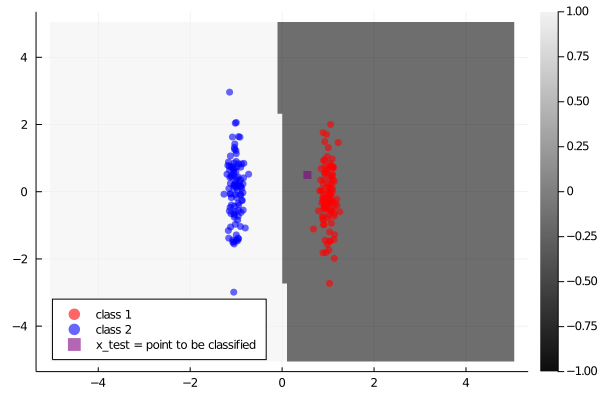

In [31]:
D = [sign(x1 * W[1] + x2 * W[2] + b[1]) for x2 in x2range, x1 in x1range]
heatmap(x1range, x2range, D; color=:grays)
scatter!(X1[1, :], X1[2, :]; color="red", label="class 1")
scatter!(X2[1, :], X2[2, :]; color="blue", label="class 2")
scatter!(
    x_test[1, :], x_test[2, :];
    color="purple",
    marker=:square,
    label="x_test = point to be classified",
    legend=:bottomleft
)

In [32]:
function point_circle(r::Number, σ::Number, N::Integer)
    ϕ = range(0; stop=2π, length=N)
    rvec = r .+ σ * randn(N)

    X = [rvec .* cos.(ϕ) rvec .* sin.(ϕ)]

    return permutedims(X)
end

point_circle (generic function with 1 method)

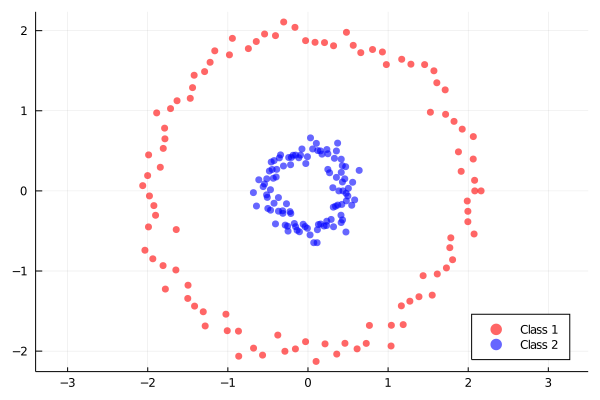

In [33]:
r1, r2 = 2, 0.5
σ = 0.1
N = 100

X1 = point_circle(r1, σ, N)
X2 = point_circle(r2, σ, N)

scatter2d(X1; color="red", label="Class 1", aspectratio=:1.0)
scatter2d!(X2; color="blue", label="Class 2", legend=:bottomright)

In [34]:
X_train = hcat(X1, X2)
y_train = [-ones(1, size(X1, 2)) ones(1, size(X2, 2))]

n, d = 8, 2
batch_size = 50

W0, b0 = rand(n, d), rand(n)
f_a, df_a = tanh, dtanh

mu = 1e-2 # start with 1e0 and decrease until the network learns
iters = 3000

W, b, empirical_loss = learn2classify_asgd_1layer(
    f_a, df_a, grad_loss_1layer_1output,
    X_train, y_train, W0, b0, mu, iters, batch_size
)

scatter_training_loss(empirical_loss, 1:5:iters)
println("Training loss is $(empirical_loss[end])")

Training loss is 0.011986667444967604


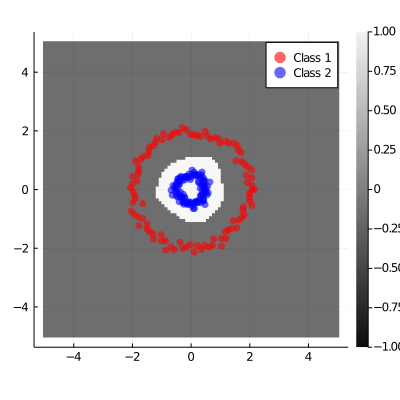

In [35]:
D = sign.([g([x1; x2], W, b, f_a)[1] for x2 in x2range, x1 in x1range])

heatmap(x1range, x2range, D; color=:grays, size=(400, 400)) 
scatter2d!(X1; color="red", label="Class 1", aspectratio=:1.0)
scatter2d!(X2; color="blue", label="Class 2")

In [36]:
n, d = 16, 2
mu = 1e-1
W0, b0 = rand(n, d), rand(n)
f_a, df_a = tanh, dtanh

W, b, empirical_loss = learn2classify_asgd_1layer(
    f_a, df_a, grad_loss_1layer_1output,
    X_train, y_train, W0, b0, mu, iters, batch_size
)

scatter_training_loss(empirical_loss, 1:5:iters)
println("Training loss is $(empirical_loss[end])")

Training loss is 0.0006346530094044456


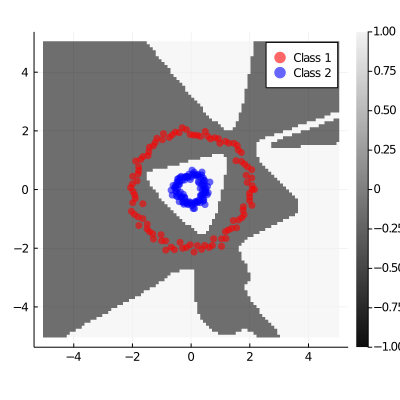

In [37]:
D = sign.([g([x1; x2], W, b, f_a)[1] for x2 in x2range, x1 in x1range])
heatmap(x1range, x2range, D; color=:grays, size=(400, 400)) 
scatter2d!(X1; color="red", label="Class 1", aspectratio=:1.0)
scatter2d!(X2; color="blue", label="Class 2")

In [38]:
"""
    dW, db, loss = grad_loss_1layer(f_a, df_a, x, y, W, b)

Inputs:
* `x` is a d x N Array{Float64,2} -- even when d = 1
* `y` is a n x N  Array{Float64,2}
* `W` is an n x d Array{Float64,2} 
* `b` is n element Array{Float64,1}

Outputs:
* `dW`: gradients with respect to weights
* `db`: gradients with respect to biases
* `loss`: loss function value
"""
function grad_loss_1layer(
        f_a::Function,
        df_a::Function, 
        x::AbstractMatrix, 
        y::AbstractMatrix, 
        W::AbstractMatrix,
        b::AbstractVector
    )

    n, d = size(W)
    N = size(y, 2) # assume y is matrix of size n x N
    
    dW = zeros(n, d) 
    db = zeros(n)
    loss = 0.0

    for k in 1:N
        for p in 1:n
            error = y[p, k] - f_a(W[p, :]' * x[:, k] + b[p])
            common_term = error * df_a(W[p, :]' * x[:, k] + b[p])
            for q in 1:d
                dW[p, q] = dW[p, q] - 2 / N * common_term * x[q, k]
            end
            db[p] = db[p] - 2 / N * common_term
            loss += 1 / N * error^2
        end
    end
    return dW, db, loss
end    

grad_loss_1layer

In [39]:
function load_digit_data(digit::Integer, nx::Integer=28, ny::Integer=28, nrep::Integer=1000)
    filepath = "data" * string(digit)
    
    x = open(filepath, "r") do file
        # what is the type of x0?
        reshape(read(file), (nx, ny, nrep))
    end
    
   return x
end

load_digit_data (generic function with 4 methods)

In [40]:
labels = [1, 5, 9]

X0 = load_digit_data(labels[1])
X1 = load_digit_data(labels[2])
X2 = load_digit_data(labels[3]);

LoadError: SystemError: opening file &quot;data1&quot;: No such file or directory

In [ ]:
"""
    v = e_i(i, n[, T])

Returns a length-`n` vector with a 1 in the `i`th position, and zeros elsewhere.
    Element type is specified with `T`.
"""
function e_i(i::Integer, n::Integer, T::Type=Float64)
    v = zeros(T, n)
    v[i] = 1

    return v
end

num_labels = length(labels)

label2vector = Dict{Int64, Vector{Float64}}()
for (i, l) in enumerate(labels)
    label2vector[l] = e_i(i, num_labels)
end

vector2label = Dict((v, k) for (k, v) in label2vector)

In [ ]:
N_per_label = 500

X_train = hcat(
    reshape(X0[:, :, 1:N_per_label], 784, :), 
    reshape(X1[:, :, 1:N_per_label], 784, :),
    reshape(X2[:, :, 1:N_per_label], 784, :)
)

Y_train = hcat(
    repeat(label2vector[1], 1, N_per_label),
    repeat(label2vector[5], 1, N_per_label),
    repeat(label2vector[9], 1, N_per_label)
)


# Note: the next two lines do the same thing as the previous 
# 12, except for test data rather than train data. It is more
# concise, and should still be readable if you are familiar
# with the "splat" ("...") operator
X_test = hcat((reshape(X[:, :, (N_per_label + 1):(2 * N_per_label)], 784, :) for X in (X0, X1, X2))...)
Y_test = hcat((repeat(label2vector[l], 1, N_per_label) for l in labels)...)

labels_test = vcat((fill(l, N_per_label) for l in labels)...)

In [ ]:
n = length(labels)
d = 784
mu = 1e-10 # start with 1e-1 and decrease until it learns
W0 = zeros(n, d)
b0 = zeros(n)
iters = 2000

W_linear, b_linear, loss_linear = learn2classify_asgd_1layer(
    linear, dlinear, grad_loss_1layer,
    X_train, Y_train, W0, b0, mu, iters
)

scatter_training_loss(loss_linear, 1:iters)
println("Training loss is $(loss_linear[end])")

In [ ]:
function heatmap_reshape_columns(img_vector::Array; nx::Integer=28, ny::Integer=28, kwargs...)
    return heatmap(
        permutedims(vcat(mapslices(v -> [reshape(v, nx, ny)], img_vector; dims=2)...));
        color=:grays,
        aspect_ratio=1.0,
        axis=false,
        grid=false,
        size=(500, 200),
        kwargs...
    )
end

heatmap_reshape_columns(W_linear; title="Reshaped rows of W_linear")

In [ ]:
function output2labels(Y::AbstractMatrix, vector2label::Dict)
    Y_ei = mapslices(v -> e_i(findmax(v)[2], length(vector2label)), Y; dims=1) # convert each col to e_i
    return mapslices(v -> vector2label[v], Y_ei; dims=1) |> vec # convert e_i to label
end

Y_linear = linear.(W_linear * X_test .+ b_linear) # raw output
predicted_labels_linear = output2labels(Y_linear, vector2label)

@show pcorrect = sum(predicted_labels_linear .== labels_test) / length(labels_test);

In [ ]:
W_tanh, b_tanh, loss_tanh = learn2classify_asgd_1layer(
    tanh, dtanh, grad_loss_1layer,
    X_train, Y_train, W0, b0, mu, iters
)

scatter_training_loss(loss_tanh, 1:iters)
println("Training loss is $(loss_tanh[end])")

In [ ]:
Y_tanh = tanh.(W_tanh * X_test .+ b_tanh) # raw output
predicted_labels_tanh = output2labels(Y_tanh, vector2label)

@show pcorrect = sum(predicted_labels_tanh .== labels_test) / length(labels_test);

In [ ]:
heatmap_reshape_columns(W_tanh; title="Weight vectors viewed as matries for tanh")

In [ ]:
include("drawnumber.jl")

In [ ]:
function predict_digit(
        app::Canvas, 
        vector2label::Dict, 
        f_a::Function, 
        W::AbstractMatrix,
        b::AbstractVector
    )
    # Use image(app, (28, 28)) to get the current image at 28x28 resolution.
    img_from_app = Gray.(image(app, (28, 28)))
    img_from_app = float(1 .- img_from_app)
    img = 255 * (img_from_app')
    
    img_vec = vec(img)
    raw_output = f_a.(W * img_vec + b) |> permutedims |> permutedims
    
    prediction = output2labels(raw_output, vector2label) |> first
    
    return img, prediction, raw_output
end

In [ ]:
app = Canvas()

In [ ]:
img, prediction, raw_output = predict_digit(app, vector2label, tanh, W_tanh, b_tanh)

p1 = heatmap_digit(img; title="Network predicts $prediction")

x = 1:length(raw_output)
p2 = bar(
    x, raw_output; 
    xlabel="label",
    ylabel="Hidden layer output",
    xticks=(x, string.(labels))
)

plot(p1, p2; layout=(1, 2), size=(800, 350))

In the cell below, enter code for training a network to distinguish all 10 digits. Use the linear activation function, and let `mu = 1e-10`.
Then run the following cell to compute `pcorrect`. What do you obtain for the probability of correct classification for the network you trained?
Hint: You will have to construct the training and test data sets. It will be helpful to plott the training loss so you can reason about the learning (or not) for the parameters you select.

In [43]:
N_per_label = 500

labels = collect(0:9)
num_labels = length(labels)
X = [load_digit_data(d) for d in labels]

label2vector = Dict{Int64, Vector{Float64}}()
for (i, l) in enumerate(labels)
    label2vector[l] = e_i(i, num_labels)
end
vector2label = Dict((v, k) for (k, v) in label2vector)

X_train = hcat((reshape(Xi[:, :, 1:N_per_label], 784, :) for Xi in X)...)
Y_train = hcat((repeat(label2vector[l], 1, N_per_label) for l in labels)...)

d = size(X_train, 1)
mu = 1e-10
W0 = zeros(num_labels, d)
b0 = zeros(num_labels)
iters = 2000

W_linear, b_linear, loss_linear = learn2classify_asgd_1layer(
    linear, dlinear, grad_loss_1layer,
    X_train, Y_train, W0, b0, mu, iters
)

scatter_training_loss(loss_linear, 1:iters)

LoadError: SystemError: opening file &quot;data0&quot;: No such file or directory

In [42]:
X_test = hcat((reshape(Xi[:, :, (N_per_label + 1):(2 * N_per_label)], 784, :) for Xi in X)...)
Y_test = hcat((repeat(label2vector[l], 1, N_per_label) for l in labels)...)

labels_test = vcat((fill(l, N_per_label) for l in labels)...)

Y_linear = linear.(W_linear * X_test .+ b_linear)
predictions_linear = output2labels(Y_linear, vector2label)

@show pcorrect = sum(predictions_linear .== labels_test) / length(labels_test);

LoadError: UndefVarError: X not defined

In [ ]:
f_a = tanh
df_a = dtanh

W_tanh, b_tanh, loss_tanh = learn2classify_asgd_1layer(
    tanh, dtanh, grad_loss_1layer,
    X_train, Y_train, W0, b0, mu, iters
)

scatter_training_loss(loss, 1:iters)

In [ ]:
Y_tanh = tanh.(W_tanh * X_test .+ b_tanh)
predictions_tanh = output2labels(Y_tanh, vector2label)

@show pcorrect = sum(predictions_tanh .== labels_test) / length(labels_test);